XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190704-150411'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings()

In [3]:
param_dist = {
    'max_depth': sp.stats.randint(1, 8),
    'learning_rate': sp.stats.uniform(0.0005, 0.5),
    'gamma': sp.stats.uniform(0, 1),
    'min_child_weight': sp.stats.randint(1, 15),
    'subsample': sp.stats.uniform(0.7, 0.3),
    'colsample_bytree': sp.stats.uniform(0.5, 0.5),
    'colsample_bylevel': sp.stats.uniform(0.5, 0.5),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2013-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

predictions = {}
actuals = {}
models = {}
for station in station_data_dict.keys():
    print(station)
    station_data = station_data_dict[station]
    
    station_train = station_data.loc[train_start : train_end].copy()
    num_validation_samples = int(validation_fraction * station_train.shape[0])
    shuffle_indices = np.arange(station_train.shape[0])
    np.random.shuffle(shuffle_indices)
    station_train = station_train.iloc[shuffle_indices]
    station_val, station_train = station_train.iloc[:num_validation_samples].copy(), station_train.iloc[num_validation_samples:].copy()
    
    station_test = station_data.loc[test_start : test_end]
    print('Shapes: train {}, val {}, test {}'.format(station_train.shape, station_val.shape, station_test.shape))

    station_val = [(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff']), 
                   (station_val.drop(['station', 'runoff'], axis=1), station_val['runoff'])]
    
    xgb_model = xgb.XGBRegressor(n_estimators=1000, n_jobs=-1, random_state=123)
    m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=3, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'], eval_set=station_val, eval_metric='rmse', early_stopping_rounds=100, verbose=False)
    
    cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
    print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
    print('Best params: {}'.format(m.best_params_))
    print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue

    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    predict['runoff'] = m.predict(predict.drop('runoff', axis=1))

    predictions[station] = predict[['runoff']]
    actuals[station] = station_test['runoff']
    models[station] = m

02GA010
Shapes: train (1308, 302), val (145, 302), test (365, 302)
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
702                0.697685               0.734437    0.615064   
999                 0.93133               0.646634    0.382414   
866                0.538872               0.570037     0.27414   
829                0.580688               0.805023    0.938497   
854                 0.52395               0.698543    0.977302   

    param_learning_rate param_max_depth param_min_child_weight  \
702            0.319229               3                      2   
999            0.138932               4                      6   
866           0.0914834               7                     10   
829            0.358649               4                      5   
854           0.0664779               6                      7   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
702         4.40265          1.97848        0.977474      -150.019209   
999         5.47995         0.280702        0.903819      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
934                0.760969                0.79346  0.00593281   
564                0.537573               0.748991    0.399486   
702                0.697685               0.734437    0.615064   
838                0.822325               0.525468    0.599462   
943                0.594327               0.908672    0.761436   

    param_learning_rate param_max_depth param_min_child_weight  \
934            0.157647               3                      1   
564            0.133108               5                      4   
702            0.319229               3                      2   
838            0.222946               3                      3   
943            0.176006               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
934         2.62991          9.00795        0.881466       -80.544849   
564         20.9824          1.44855        0.785521       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
720                0.630011               0.827082    0.160961   
984                0.772384               0.934323    0.738864   
377                0.665154               0.988153   0.0984788   
866                0.538872               0.570037     0.27414   
352                0.507702               0.660768    0.594696   

    param_learning_rate param_max_depth param_min_child_weight  \
720            0.025658               6                      9   
984           0.0300861               4                     12   
377            0.475644               7                     11   
866           0.0914834               7                     10   
352            0.170511               6                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
720         40.2459          1.60956        0.862695       -51.674842   
984         21.8828           0.1246        0.985984       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
529                 0.94792               0.904572    0.859321   
361                0.635497               0.702826    0.342137   
49                 0.659906               0.990251    0.156558   
778                0.638017               0.782567    0.340173   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
529            0.228991               2                     11   
361           0.0313684               3                     14   
49             0.102632               2                     10   
778            0.150131               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -30.08567

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 20.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
705                0.577785                0.85421    0.557641   
361                0.635497               0.702826    0.342137   
474                0.744283               0.504195    0.178761   
526                0.951715               0.803375     0.74148   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
705           0.0154785               3                      8   
361           0.0313684               3                     14   
474           0.0650908               3                     13   
526           0.0156532               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644     -1944.199400   
705         3.96708          8.68276        0.708016     -19

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
480                0.592368               0.882321    0.700754   
769                0.665892               0.887955    0.732138   
416                 0.82706               0.678458    0.843413   
153                0.949979               0.854821    0.528818   
992                0.925969               0.675503     0.53926   

    param_learning_rate param_max_depth param_min_child_weight  \
480           0.0644897               6                      1   
769           0.0483023               6                      1   
416           0.0288661               3                      4   
153           0.0275494               6                      2   
992           0.0176548               7                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
480         19.8125         0.196772        0.715484       -14.105870   
769         2.66931         0.658186        0.798171       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
219                0.572976               0.759947    0.731344   
813                0.550616               0.633077    0.848938   
495                0.621018               0.601944    0.216999   
786                0.867168               0.927076    0.625422   
725                0.756131               0.755407    0.450907   

    param_learning_rate param_max_depth param_min_child_weight  \
219            0.158015               3                      3   
813            0.186383               3                      3   
495            0.432603               3                      1   
786           0.0733598               6                      4   
725           0.0719324               5                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
219         18.9237          3.45168        0.707353       -55.429644   
813         2.42473          23.4065        0.769794       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
361                0.635497               0.702826    0.342137   
416                 0.82706               0.678458    0.843413   
250                0.506491               0.846923    0.988558   
705                0.577785                0.85421    0.557641   
595                0.566241               0.577266    0.364028   

    param_learning_rate param_max_depth param_min_child_weight  \
361           0.0313684               3                     14   
416           0.0288661               3                      4   
250           0.0438701               2                      7   
705           0.0154785               3                      8   
595           0.0468124               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
361         2.76313          11.4395        0.788409       -11.024294   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
943                0.594327               0.908672    0.761436   
210                0.553604               0.826365    0.672919   
751                0.575382               0.795855    0.342998   
631                 0.80872               0.633637    0.557289   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
943            0.176006               3                      4   
210            0.162053               2                      3   
751            0.189597               2                      1   
631            0.145192               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -21.308776   
943          6.9341          1.55189        0.986938       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
375                0.832248               0.983253    0.907692   
492                0.917807               0.873372    0.725742   
734                0.817973               0.722644    0.242889   
438                0.659231               0.737731    0.477479   
786                0.867168               0.927076    0.625422   

    param_learning_rate param_max_depth param_min_child_weight  \
375            0.221552               5                      3   
492             0.21157               6                      5   
734            0.208001               6                      9   
438           0.0171959               6                      9   
786           0.0733598               6                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
375         20.7093          10.8146        0.707002       -37.019050   
492          2.6498          9.83637        0.920537       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
188                0.599664               0.635155    0.897303   
650                0.702047               0.879628    0.667817   
635                0.830105               0.761715    0.191947   
999                 0.93133               0.646634    0.382414   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
188           0.0551259               4                      3   
650           0.0709069               2                      6   
635           0.0346263               5                      8   
999            0.138932               4                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -45.677214   
188         18.7579          3.18025        0.871764       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
528                0.502221               0.570659    0.389887   
813                0.550616               0.633077    0.848938   
280                0.727482               0.547207    0.864732   
8                  0.587686               0.657483    0.891109   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
528           0.0229117               4                      1   
813            0.186383               3                      3   
280           0.0469065               5                     11   
8             0.0906681               7                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -19.788847   
528         14.4564          19.0234        0.772747       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
943                0.594327               0.908672    0.761436   
527                0.897247               0.781905    0.499319   
935                0.571277               0.921842    0.543975   
175                0.868993               0.518677    0.804882   
915                0.533277               0.515271    0.939415   

    param_learning_rate param_max_depth param_min_child_weight  \
943            0.176006               3                      4   
527            0.338243               5                      5   
935            0.159025               6                      5   
175            0.433122               2                      4   
915            0.234738               7                      6   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
943          6.9341          1.55189        0.986938       -15.152534   
527         8.03541          12.9282        0.874347       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
854                 0.52395               0.698543    0.977302   
235                0.989196               0.793802    0.875358   
595                0.566241               0.577266    0.364028   
679                0.645637               0.737183    0.849544   
564                0.537573               0.748991    0.399486   

    param_learning_rate param_max_depth param_min_child_weight  \
854           0.0664779               6                      7   
235            0.146249               3                     13   
595           0.0468124               2                      1   
679            0.228244               2                      3   
564            0.133108               5                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
854         10.2127          10.4468        0.740287       -93.380740   
235        0.253299          11.2751        0.701365       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
250                0.506491               0.846923    0.988558   
705                0.577785                0.85421    0.557641   
416                 0.82706               0.678458    0.843413   
210                0.553604               0.826365    0.672919   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
250           0.0438701               2                      7   
705           0.0154785               3                      8   
416           0.0288661               3                      4   
210            0.162053               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -216.558280   
250         7.29803          13.9037        0.837867      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
586                 0.88516               0.906697    0.661307   
549                0.985824                0.51691   0.0618481   
660                0.812077               0.504761   0.0949222   
231                0.545484               0.675798    0.525642   
154                0.586589               0.798418    0.124704   

    param_learning_rate param_max_depth param_min_child_weight  \
586            0.100151               7                     12   
549           0.0585903               5                     13   
660            0.100846               5                     12   
231            0.122587               6                     13   
154            0.119775               5                     14   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
586           1.741          20.5964        0.802226       -39.120187   
549         6.06564          3.73224        0.911315       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
28                 0.657572               0.745755    0.820142   
705                0.577785                0.85421    0.557641   
361                0.635497               0.702826    0.342137   
188                0.599664               0.635155    0.897303   
595                0.566241               0.577266    0.364028   

    param_learning_rate param_max_depth param_min_child_weight  \
28            0.0668102               5                     10   
705           0.0154785               3                      8   
361           0.0313684               3                     14   
188           0.0551259               4                      3   
595           0.0468124               2                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
28          11.8196         0.835911        0.790155       -83.389099   
705         3.96708          8.68276        0.708016       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
725                0.756131               0.755407    0.450907   
331                0.635072               0.960828    0.592652   
302                0.728084                0.82745    0.596849   
605                0.775028               0.950122    0.239294   
481                0.773637               0.545367    0.606986   

    param_learning_rate param_max_depth param_min_child_weight  \
725           0.0719324               5                      3   
331           0.0678305               4                      3   
302           0.0365759               7                      4   
605            0.216704               3                      3   
481           0.0869274               3                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
725         9.80721          6.46099        0.756267       -24.636300   
331         1.98385          29.3796        0.766596       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
74                 0.562577               0.969394    0.774507   
528                0.502221               0.570659    0.389887   
433                0.783793               0.744009    0.151558   
725                0.756131               0.755407    0.450907   
141                0.958277               0.806007    0.162069   

    param_learning_rate param_max_depth param_min_child_weight  \
74             0.176348               4                      1   
528           0.0229117               4                      1   
433            0.203305               4                      1   
725           0.0719324               5                      3   
141           0.0202051               6                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
74          21.3674          16.5059        0.879041      -173.707987   
528         14.4564          19.0234        0.772747      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
331                0.635072               0.960828    0.592652   
11                 0.699093               0.852479    0.995358   
480                0.592368               0.882321    0.700754   
371                0.827969               0.661699    0.378886   
984                0.772384               0.934323    0.738864   

    param_learning_rate param_max_depth param_min_child_weight  \
331           0.0678305               4                      3   
11             0.178457               5                      5   
480           0.0644897               6                      1   
371           0.0545491               5                     10   
984           0.0300861               4                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
331         1.98385          29.3796        0.766596       -14.278110   
11           0.8796           41.597        0.787776       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
992                0.925969               0.675503     0.53926   
153                0.949979               0.854821    0.528818   
480                0.592368               0.882321    0.700754   
416                 0.82706               0.678458    0.843413   
959                0.676134               0.857805    0.534803   

    param_learning_rate param_max_depth param_min_child_weight  \
992           0.0176548               7                      3   
153           0.0275494               6                      2   
480           0.0644897               6                      1   
416           0.0288661               3                      4   
959            0.150791               6                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
992         2.88438          2.65157        0.792856       -11.372717   
153         9.56207           3.7639        0.746856       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
211                0.792922               0.923409    0.939502   
635                0.830105               0.761715    0.191947   
502                0.898642                0.77258     0.59956   
526                0.951715               0.803375     0.74148   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
211          0.00983328               4                      9   
635           0.0346263               5                      8   
502            0.173053               2                      2   
526           0.0156532               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -16.576440   
211         8.19451          2.36558         0.79782       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  4.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
992                0.925969               0.675503     0.53926   
593                0.513264               0.686117    0.565436   
47                  0.78116               0.715743    0.360565   
343                 0.81816               0.603247    0.745185   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
992           0.0176548               7                      3   
593            0.167012               1                      1   
47              0.25983               1                      1   
343           0.0524398               7                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -46.948078   
992         2.88438          2.65157        0.792856       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.6min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
211                0.792922               0.923409    0.939502   
705                0.577785                0.85421    0.557641   
438                0.659231               0.737731    0.477479   
210                0.553604               0.826365    0.672919   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
211          0.00983328               4                      9   
705           0.0154785               3                      8   
438           0.0171959               6                      9   
210            0.162053               2                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644      -157.103923   
211         8.19451          2.36558         0.79782      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
934                0.760969                0.79346  0.00593281   
249                0.629313               0.737625     0.23536   
121                0.602899               0.645328    0.954378   
769                0.665892               0.887955    0.732138   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
934            0.157647               3                      1   
249            0.282615               2                      1   
121           0.0439009               7                      1   
769           0.0483023               6                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003        -3.784583   
934         2.62991          9.00795        0.881466        

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
302                0.728084                0.82745    0.596849   
249                0.629313               0.737625     0.23536   
502                0.898642                0.77258     0.59956   
797                0.640033               0.794329    0.363515   
253                0.848471               0.565149    0.972714   

    param_learning_rate param_max_depth param_min_child_weight  \
302           0.0365759               7                      4   
249            0.282615               2                      1   
502            0.173053               2                      2   
797            0.212367               2                      3   
253           0.0572363               4                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
302        0.949529          14.0887        0.731958       -24.133703   
249        0.995682          1.45319         0.80564       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.3min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
213                0.901633               0.886139    0.147996   
416                 0.82706               0.678458    0.843413   
355                0.794846               0.616141    0.786606   
595                0.566241               0.577266    0.364028   
528                0.502221               0.570659    0.389887   

    param_learning_rate param_max_depth param_min_child_weight  \
213           0.0461555               4                      7   
416           0.0288661               3                      4   
355           0.0160179               4                      4   
595           0.0468124               2                      1   
528           0.0229117               4                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
213         1.62598          32.7874        0.714266       -88.720345   
416         1.64138          3.80913        0.854644       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
593                0.513264               0.686117    0.565436   
540                0.866286               0.532268    0.164171   
728                0.636089               0.967566    0.118681   
758                 0.66475               0.876361    0.634117   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
593            0.167012               1                      1   
540            0.393617               1                      9   
728            0.139296               1                     11   
758            0.276485               1                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003      -636.936301   
593         11.3059          8.84343        0.995033      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
767                0.631204               0.621164     0.59367   
122                0.817042               0.632199    0.690915   
705                0.577785                0.85421    0.557641   
371                0.827969               0.661699    0.378886   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
767           0.0619875               5                      2   
122            0.174073               6                      7   
705           0.0154785               3                      8   
371           0.0545491               5                     10   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -24.795544   
767          13.084          64.6182        0.772927       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 37.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
988                0.535237               0.827283    0.758517   
414                0.531336               0.818494    0.337249   
595                0.566241               0.577266    0.364028   
285                0.511362               0.976563     0.90244   
675                0.528276               0.715534     0.87489   

    param_learning_rate param_max_depth param_min_child_weight  \
988            0.101863               1                      2   
414             0.13073               1                      2   
595           0.0468124               2                      1   
285            0.190275               1                      1   
675           0.0300169               1                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
988         40.0325          15.4374        0.752991    -34524.068172   
414         39.2335          16.9461        0.951013    -347

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.4min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
480                0.592368               0.882321    0.700754   
188                0.599664               0.635155    0.897303   
416                 0.82706               0.678458    0.843413   
999                 0.93133               0.646634    0.382414   
769                0.665892               0.887955    0.732138   

    param_learning_rate param_max_depth param_min_child_weight  \
480           0.0644897               6                      1   
188           0.0551259               4                      3   
416           0.0288661               3                      4   
999            0.138932               4                      6   
769           0.0483023               6                      1   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
480         19.8125         0.196772        0.715484      -550.699766   
188         18.7579          3.18025        0.871764      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
421                0.911997               0.691764    0.429104   
416                 0.82706               0.678458    0.843413   
206                0.796976               0.552984    0.685345   
751                0.575382               0.795855    0.342998   
526                0.951715               0.803375     0.74148   

    param_learning_rate param_max_depth param_min_child_weight  \
421            0.295821               4                     10   
416           0.0288661               3                      4   
206            0.108453               2                      8   
751            0.189597               2                      1   
526           0.0156532               3                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
421         21.0376          3.30753        0.941577      -152.551030   
416         1.64138          3.80913        0.854644      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
416                 0.82706               0.678458    0.843413   
529                 0.94792               0.904572    0.859321   
934                0.760969                0.79346  0.00593281   
984                0.772384               0.934323    0.738864   
864                0.768427                0.77546     0.63341   

    param_learning_rate param_max_depth param_min_child_weight  \
416           0.0288661               3                      4   
529            0.228991               2                     11   
934            0.157647               3                      1   
984           0.0300861               4                     12   
864            0.349512               3                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
416         1.64138          3.80913        0.854644       -53.750555   
529          1.9684         0.270873        0.981977       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 15.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
327                0.789511               0.906452    0.150078   
53                 0.528802               0.692911    0.733229   
496                0.502672               0.960041    0.971255   
367                0.728653               0.620521    0.227129   
502                0.898642                0.77258     0.59956   

    param_learning_rate param_max_depth param_min_child_weight  \
327            0.180564               2                      6   
53            0.0684254               2                      1   
496            0.117535               2                      1   
367            0.253848               2                     10   
502            0.173053               2                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
327          14.604             3.57        0.960825     -2895.431614   
53          61.5035          2.17131        0.887563     -29

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
62                 0.946933               0.748254    0.426096   
160                0.610895               0.589115    0.463975   
310                0.833296               0.597665    0.174419   
481                0.773637               0.545367    0.606986   
325                0.619574               0.879795   0.0225494   

    param_learning_rate param_max_depth param_min_child_weight  \
62             0.153323               3                      1   
160            0.146983               2                      1   
310            0.140612               3                      2   
481           0.0869274               3                     12   
325            0.277434               2                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
62          38.9896          51.1192        0.791014      -532.764754   
160         37.5946          71.2657        0.749302      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
120                0.702269               0.913265    0.326236   
557                0.974198                0.71318   0.0963781   
3                  0.708605               0.827361    0.373801   
481                0.773637               0.545367    0.606986   
789                0.828341               0.531067    0.399781   

    param_learning_rate param_max_depth param_min_child_weight  \
120            0.242108               2                      6   
557            0.108288               3                     12   
3              0.117756               5                      9   
481           0.0869274               3                     12   
789           0.0486125               3                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
120          7.3851          20.4175        0.794549      -232.817630   
557         10.4272          29.6488        0.860304      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.7min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
235                0.989196               0.793802    0.875358   
995                0.541595                 0.5069    0.505431   
157                0.991796                0.63942    0.101912   
771                0.517895               0.521961    0.531342   
234                0.731579               0.631457     0.77759   

    param_learning_rate param_max_depth param_min_child_weight  \
235            0.146249               3                     13   
995            0.438744               2                      1   
157            0.146573               3                      7   
771            0.262061               2                     11   
234            0.271957               3                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
235        0.253299          11.2751        0.701365      -516.097751   
995         13.2544          1.00659        0.960582      -5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.2min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
732                0.556124               0.837871   0.0247203   
416                 0.82706               0.678458    0.843413   
679                0.645637               0.737183    0.849544   
705                0.577785                0.85421    0.557641   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
732            0.276532               2                      3   
416           0.0288661               3                      4   
679            0.228244               2                      3   
705           0.0154785               3                      8   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -13.038628   
732         2.58481          3.10019        0.747109       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 10.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
544                0.781954               0.797392    0.310562   
53                 0.528802               0.692911    0.733229   
747                0.998425               0.679755   0.0379134   
705                0.577785                0.85421    0.557641   
430                0.733482               0.521539    0.435679   

    param_learning_rate param_max_depth param_min_child_weight  \
544           0.0448832               2                      6   
53            0.0684254               2                      1   
747           0.0860007               6                     12   
705           0.0154785               3                      8   
430             0.19881               2                     13   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
544         23.0275          16.8007        0.701893      -609.366595   
53          61.5035          2.17131        0.887563      -6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  5.1min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
276                0.600355               0.732061     0.78045   
544                0.781954               0.797392    0.310562   
201                0.641027                0.61135    0.738389   
3                  0.708605               0.827361    0.373801   
313                0.601473               0.630255    0.121017   

    param_learning_rate param_max_depth param_min_child_weight  \
276            0.214404               2                     10   
544           0.0448832               2                      6   
201            0.207096               2                     11   
3              0.117756               5                      9   
313            0.237904               2                     12   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
276         29.3757           16.764        0.824662      -214.260517   
544         23.0275          16.8007        0.701893      -2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  9.9min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
650                0.702047               0.879628    0.667817   
489                0.526796               0.974276    0.629412   
526                0.951715               0.803375     0.74148   
854                 0.52395               0.698543    0.977302   
3                  0.708605               0.827361    0.373801   

    param_learning_rate param_max_depth param_min_child_weight  \
650           0.0709069               2                      6   
489            0.088437               7                     11   
526           0.0156532               3                      5   
854           0.0664779               6                      7   
3              0.117756               5                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
650         15.2017          8.02298        0.830693      -840.436243   
489         7.53573          16.4511           0.792      -8

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
595                0.566241               0.577266    0.364028   
694                0.565098               0.640605    0.605024   
416                 0.82706               0.678458    0.843413   
188                0.599664               0.635155    0.897303   
153                0.949979               0.854821    0.528818   

    param_learning_rate param_max_depth param_min_child_weight  \
595           0.0468124               2                      1   
694           0.0753603               6                      2   
416           0.0288661               3                      4   
188           0.0551259               4                      3   
153           0.0275494               6                      2   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
595         2.16514         0.317428        0.818003       -98.203524   
694         1.46139          3.46522        0.983391      -1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
219                0.572976               0.759947    0.731344   
711                0.760833               0.536818   0.0287974   
822                0.849294               0.586778    0.350285   
674                0.587975                0.98573    0.141924   
343                 0.81816               0.603247    0.745185   

    param_learning_rate param_max_depth param_min_child_weight  \
219            0.158015               3                      3   
711            0.285149               4                      1   
822             0.26912               5                      9   
674            0.146919               4                      1   
343           0.0524398               7                      3   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
219         18.9237          3.45168        0.707353      -431.074058   
711         5.70634          16.8118        0.938143      -4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   59.2s finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are

    param_colsample_bylevel param_colsample_bytree param_gamma  \
977                0.528022               0.501192    0.797742   
182                0.774572               0.631505    0.566366   
120                0.702269               0.913265    0.326236   
430                0.733482               0.521539    0.435679   
945                0.824456               0.587443    0.346351   

    param_learning_rate param_max_depth param_min_child_weight  \
977            0.243906               6                      1   
182             0.36466               3                      5   
120            0.242108               2                      6   
430             0.19881               2                     13   
945             0.28331               4                      4   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
977         10.0288          2.87195        0.717617       -79.506933   
182        0.597127          9.56154        0.732151       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.8min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
868                0.995897               0.686441     0.31698   
438                0.659231               0.737731    0.477479   
847                 0.84931               0.756204    0.691709   
531                0.807299               0.939865    0.268678   
81                 0.992064               0.613901    0.589415   

    param_learning_rate param_max_depth param_min_child_weight  \
868            0.171258               5                     12   
438           0.0171959               6                      9   
847           0.0559105               5                      5   
531           0.0483353               6                      9   
81             0.294308               7                      5   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
868         28.2668          9.59296        0.743239       -39.484777   
438         19.2088          4.09495         0.75852       -

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2416 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  2.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.

    param_colsample_bylevel param_colsample_bytree param_gamma  \
558                0.567332               0.830958    0.949966   
725                0.756131               0.755407    0.450907   
528                0.502221               0.570659    0.389887   
331                0.635072               0.960828    0.592652   
908                0.721776               0.755958   0.0863256   

    param_learning_rate param_max_depth param_min_child_weight  \
558            0.256704               4                      8   
725           0.0719324               5                      3   
528           0.0229117               4                      1   
331           0.0678305               4                      3   
908            0.135682               5                      9   

    param_reg_alpha param_reg_lambda param_subsample  mean_test_score  \
558         71.0849          6.70832        0.857748       -78.925868   
725         9.80721          6.46099        0.756267       -

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


02GA010 	NSE: 0.11548611376135476 	MSE: 438.05368849378004 (clipped to 0)
02GA018 	NSE: 0.3337702574352448 	MSE: 140.76556066098598 (clipped to 0)
02GA038 	NSE: 0.2533465766002191 	MSE: 123.6039950050012 (clipped to 0)
02GA047 	NSE: 0.27051816259240213 	MSE: 59.047613202620084 (clipped to 0)
02GB001 	NSE: 0.21779307726723607 	MSE: 6246.85046853982 (clipped to 0)
02GB007 	NSE: 0.35712502728246276 	MSE: 16.104685440306056 (clipped to 0)
02GC002 	NSE: 0.578127751096926 	MSE: 26.949972589752523 (clipped to 0)
02GC007 	NSE: 0.44029262223090493 	MSE: 12.524263795196598 (clipped to 0)
02GC010 	NSE: 0.4359274013226945 	MSE: 15.438806739078494 (clipped to 0)
02GC018 	NSE: 0.46145868416460434 	MSE: 20.218043214154417 (clipped to 0)
02GC026 	NSE: 0.4345827555550291 	MSE: 59.28431864322868 (clipped to 0)
02GD004 	NSE: 0.31632188342293244 	MSE: 30.20883789432447 (clipped to 0)
02GE007 	NSE: 0.2368491453931596 	MSE: 23.483349007831485 (clipped to 0)
02GG002 	NSE: 0.20273753883719936 	MSE: 145.890191

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04160600 	NSE: 0.5244333114290158 	MSE: 7.433466322296037 (clipped to 0)
04161820 	NSE: 0.43941662808850745 	MSE: 13.408554006272244 (clipped to 0)
04164000 	NSE: 0.5344098241289676 	MSE: 98.0774349268844 (clipped to 0)
04165500 	NSE: 0.4819930188803271 	MSE: 238.6303697624589 (clipped to 0)
04166100 	NSE: 0.45809417820343634 	MSE: 3.201779397372476 (clipped to 0)
04166500 	NSE: 0.464297297321308 	MSE: 19.59067135067886 (clipped to 0)
04174500 	NSE: 0.4515420844609056 	MSE: 57.61201925742976 (clipped to 0)
04176500 	NSE: 0.23127212820437826 	MSE: 645.0129644274552 (clipped to 0)
04177000 	NSE: -0.14320142221407606 	MSE: 32.59921233194107 (clipped to 0)
04193500 	NSE: 0.43544350593568115 	MSE: 37352.98936835313 (clipped to 0)


../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: Ru

04195820 	NSE: 0.3707230551118036 	MSE: 417.5157948292293 (clipped to 0)
04196800 	NSE: 0.08757386442656656 	MSE: 148.94104725130774 (clipped to 0)
04197100 	NSE: 0.5114004757035326 	MSE: 29.96429789643929 (clipped to 0)
04198000 	NSE: 0.17572469767512433 	MSE: 3097.0855256144087 (clipped to 0)
04199000 	NSE: 0.4294636187413148 	MSE: 311.9070037321864 (clipped to 0)
04199500 	NSE: 0.4705464405456862 	MSE: 151.3537958882841 (clipped to 0)
04200500 	NSE: 0.44844004606503685 	MSE: 429.60178845387986 (clipped to 0)
04207200 	NSE: 0.620053205678961 	MSE: 9.248788522184052 (clipped to 0)
04208504 	NSE: 0.6053159390916623 	MSE: 381.9824762531278 (clipped to 0)
04209000 	NSE: 0.43743002142626386 	MSE: 165.5051326725248 (clipped to 0)
04212100 	NSE: 0.5950061762601242 	MSE: 488.8102953277235 (clipped to 0)
04213000 	NSE: 0.347468346148044 	MSE: 93.72179453272413 (clipped to 0)
04213500 	NSE: 0.5328049699140314 	MSE: 205.73739362959498 (clipped to 0)
04214500 	NSE: 0.22768140945338977 	MSE: 68.4

../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


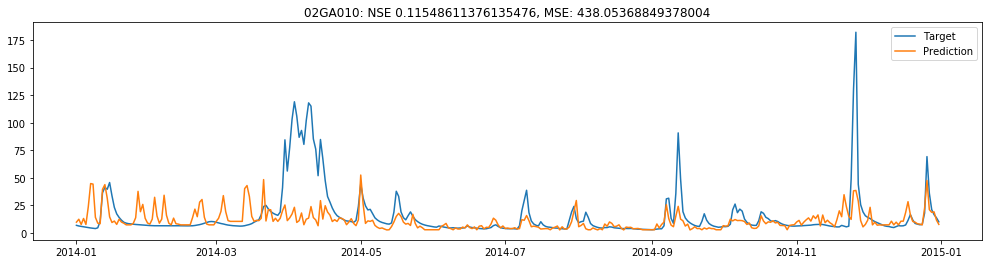

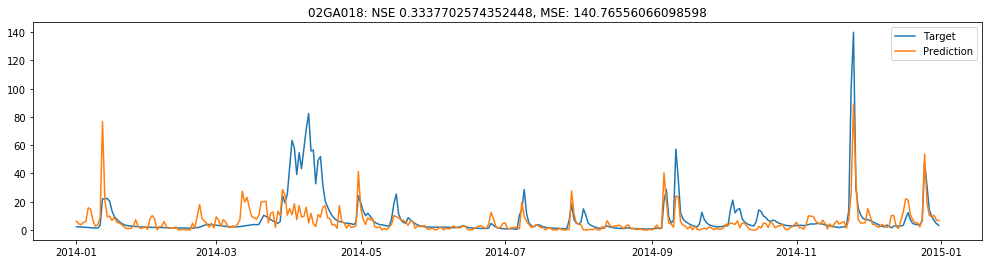

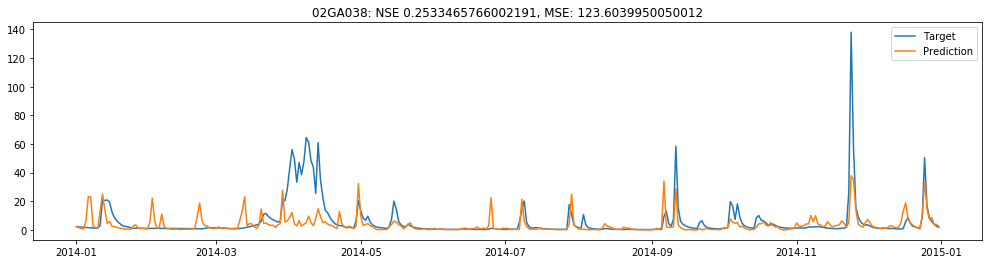

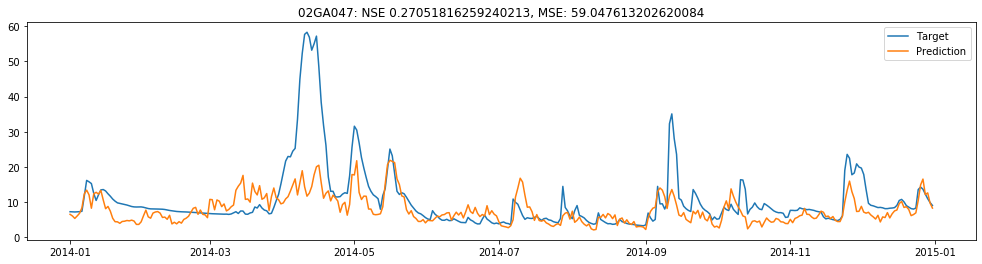

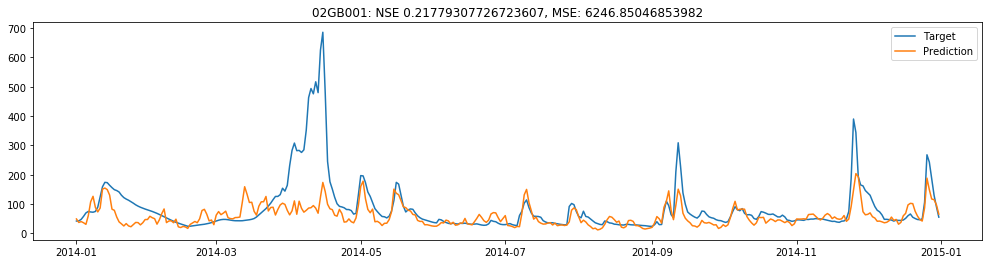

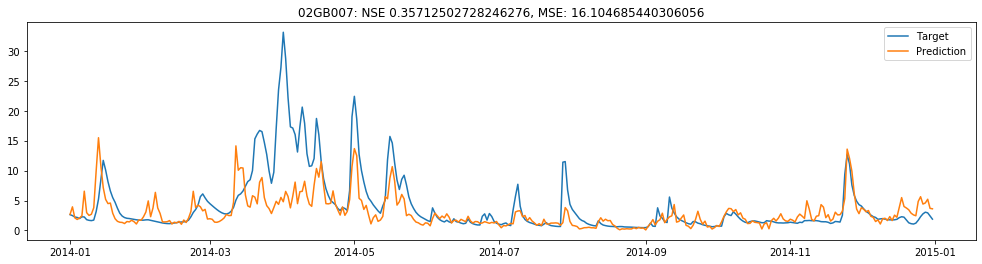

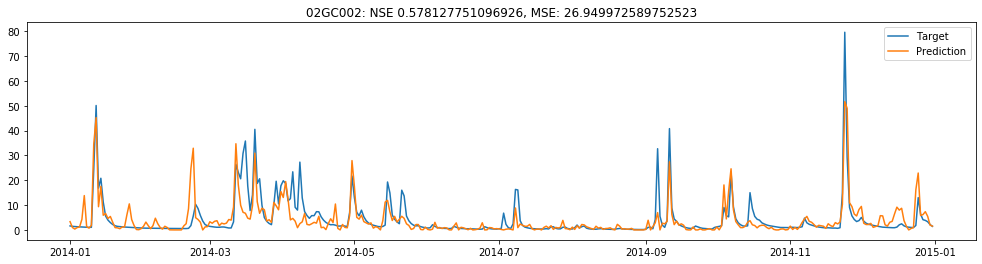

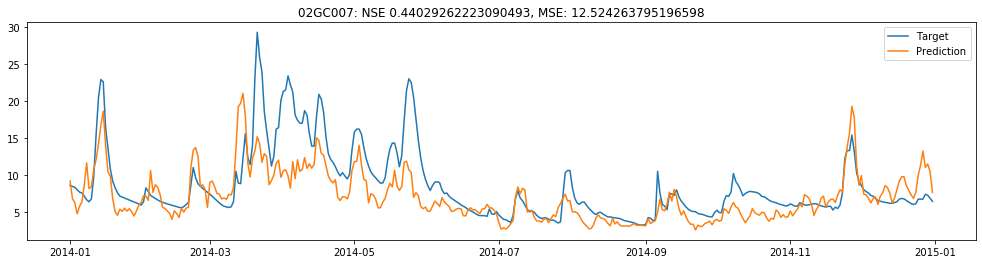

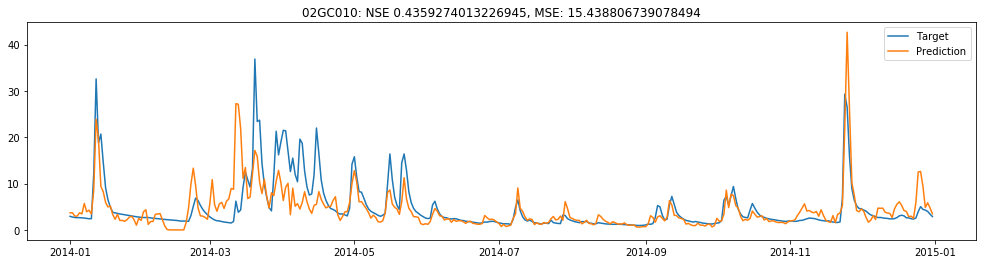

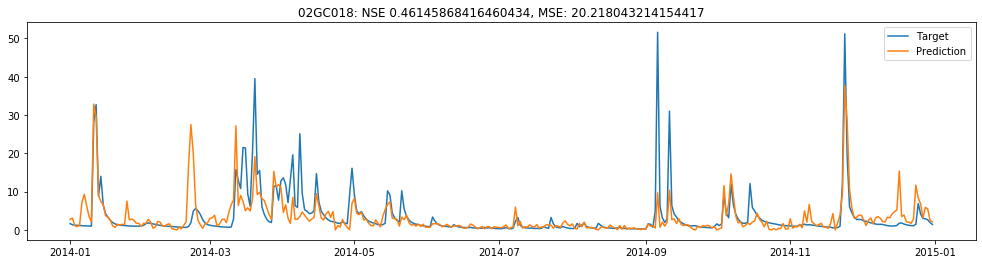

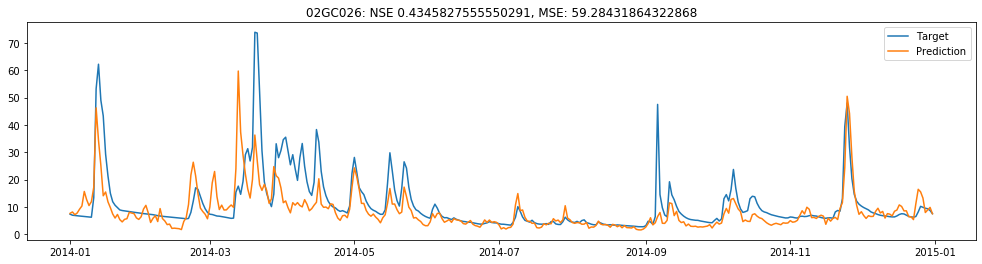

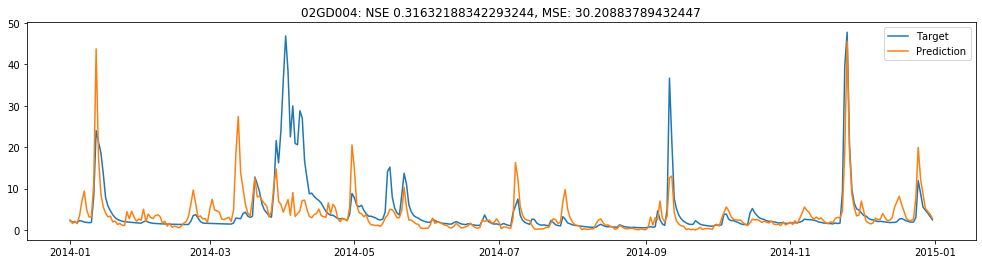

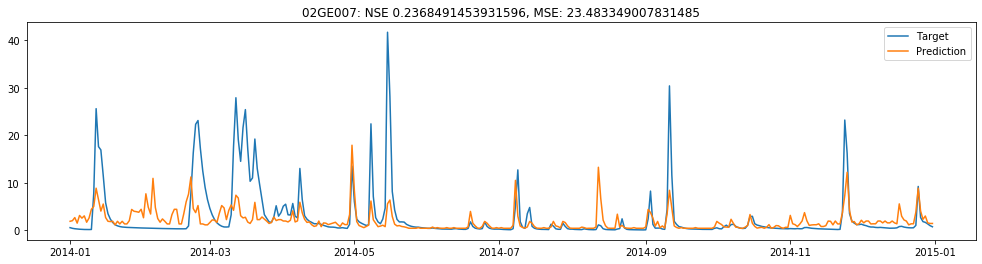

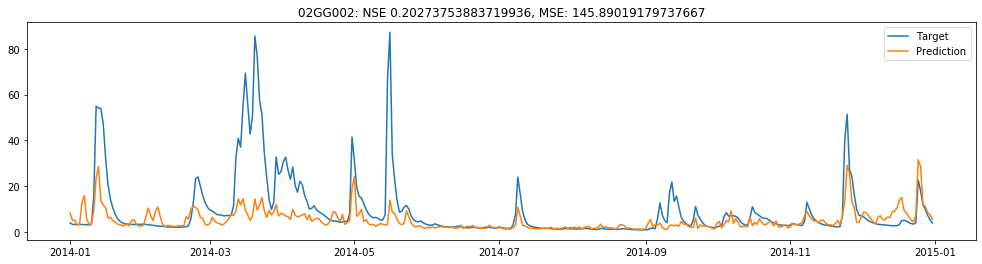

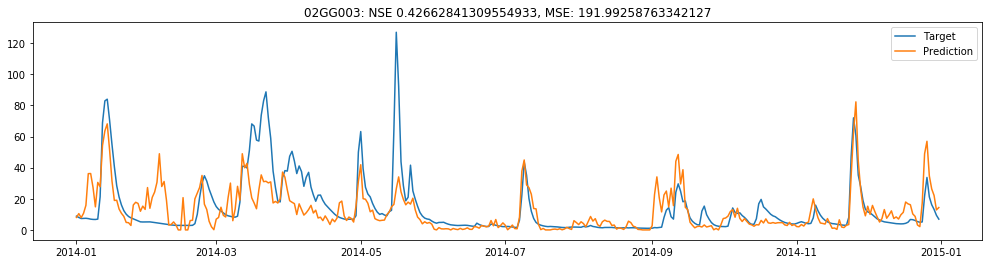

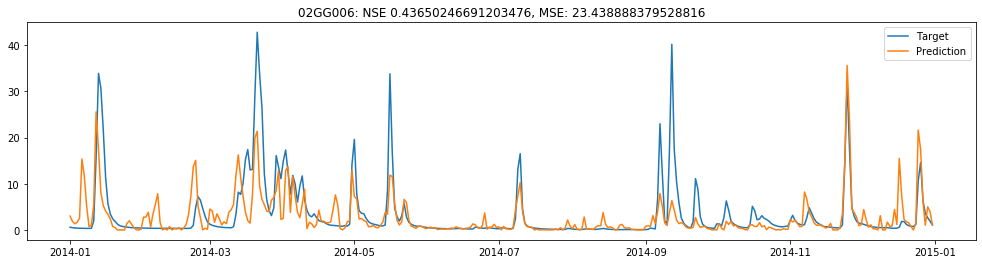

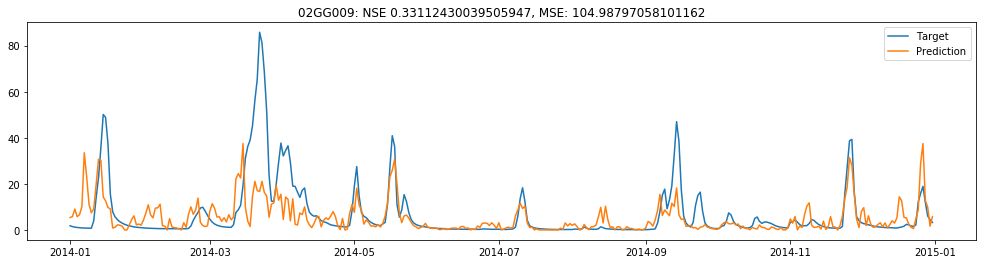

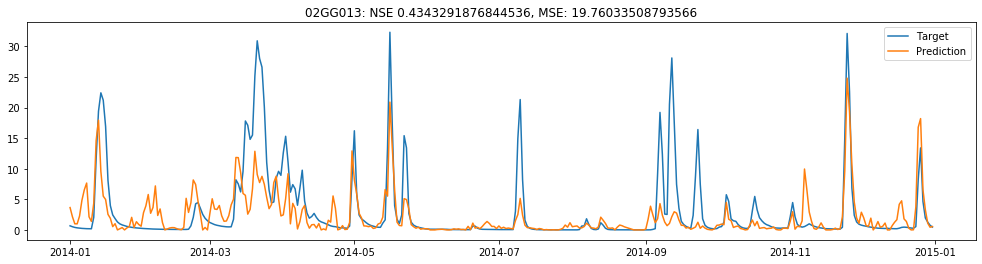

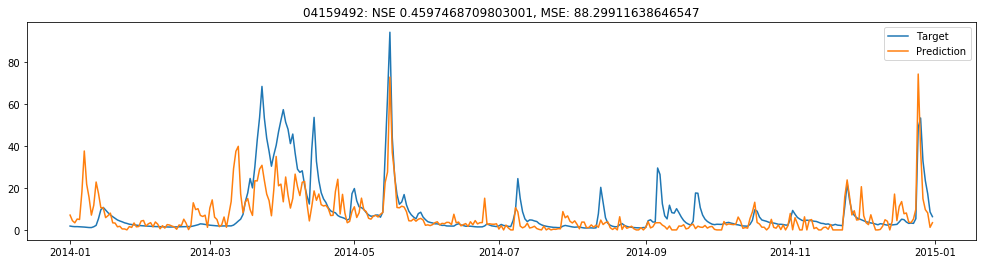

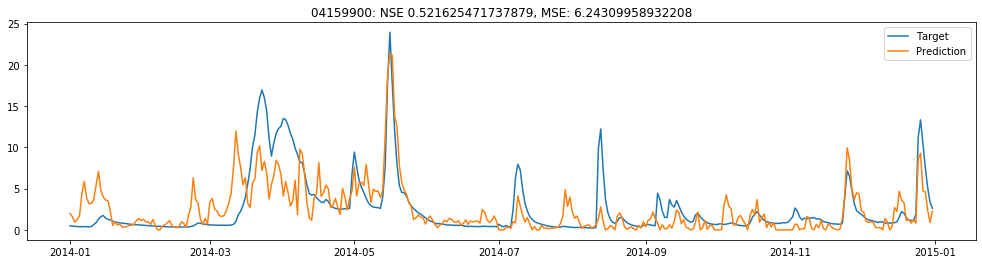

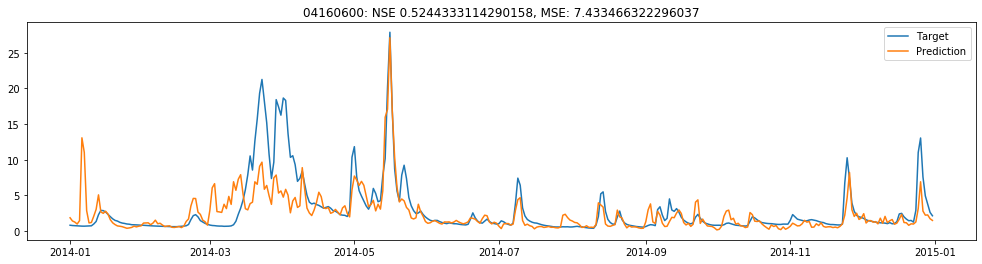

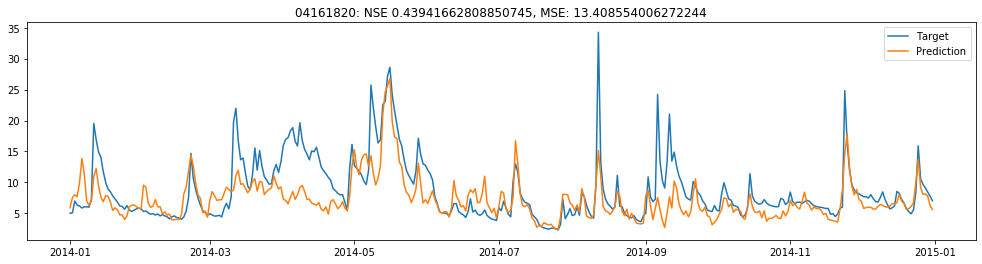

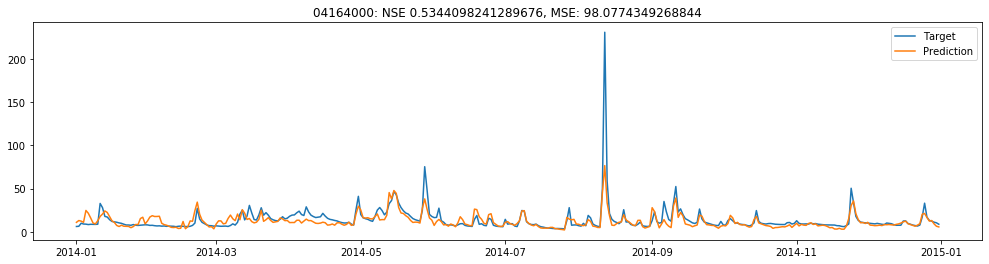

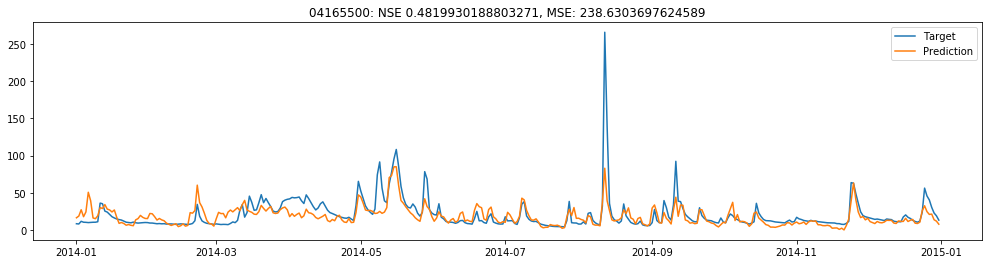

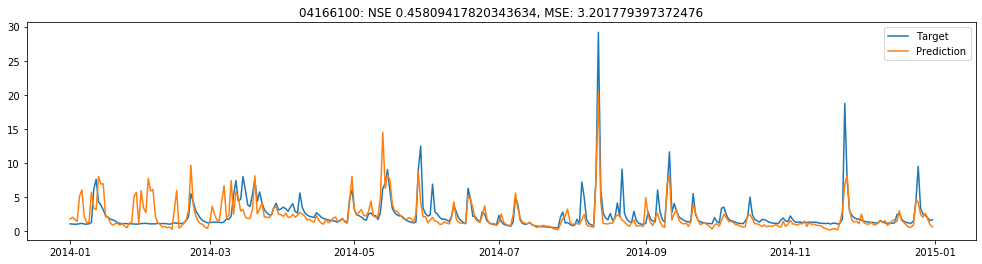

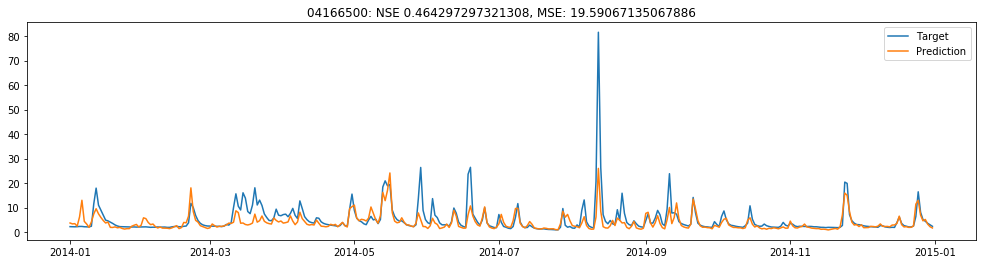

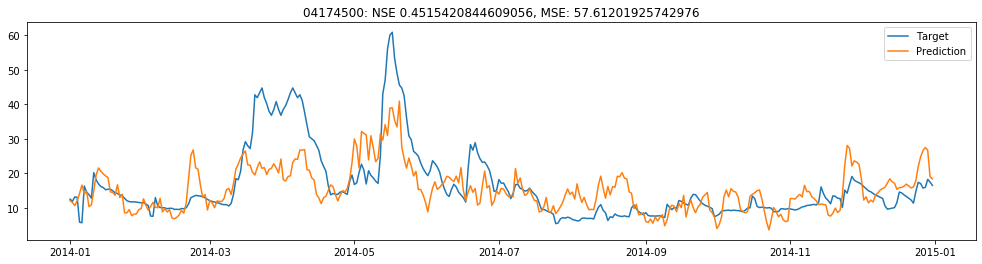

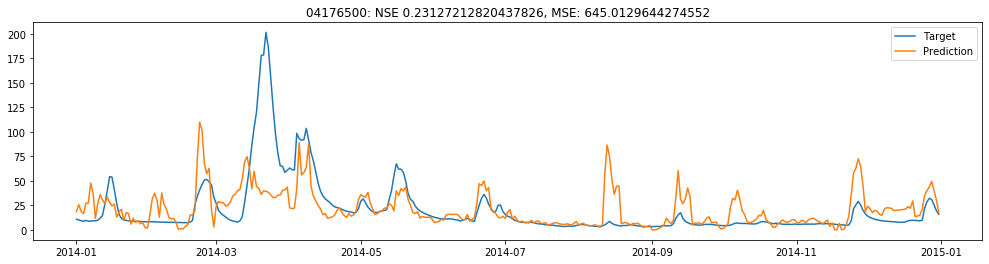

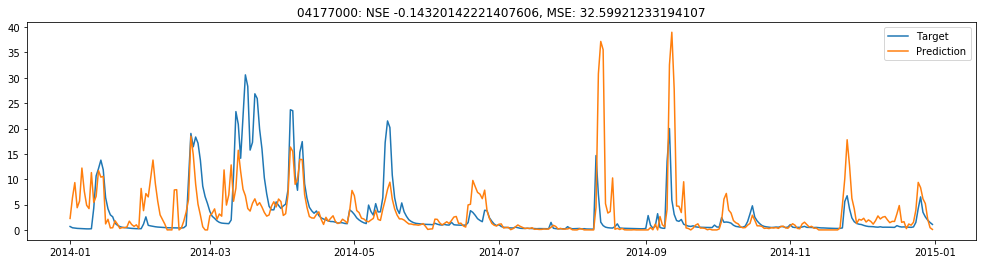

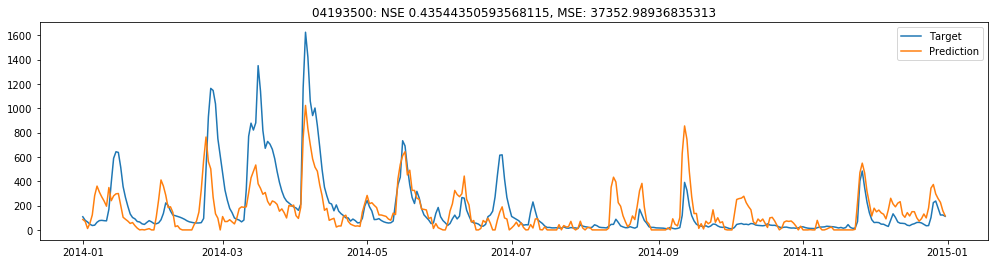

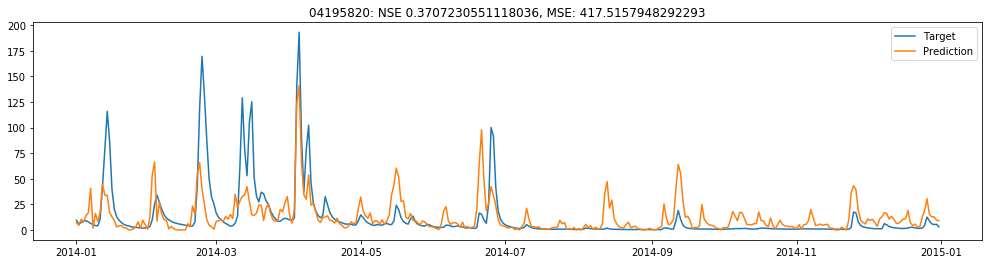

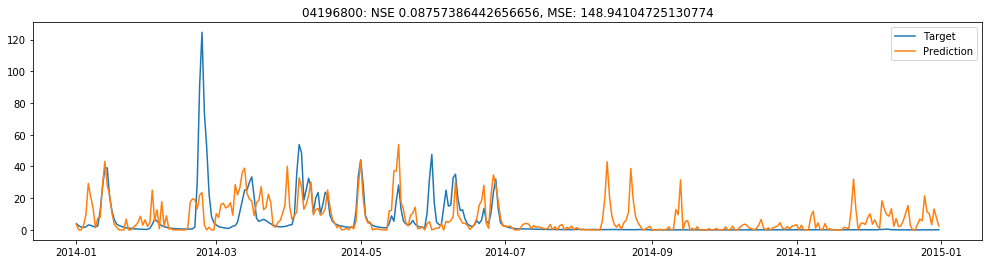

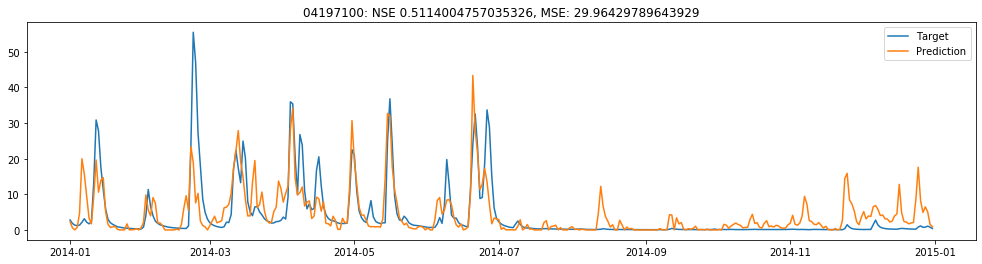

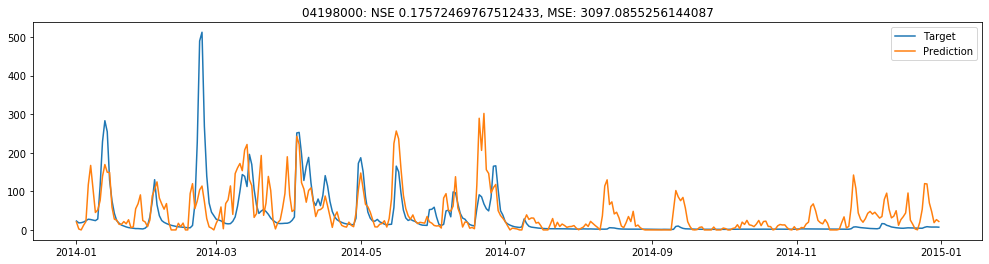

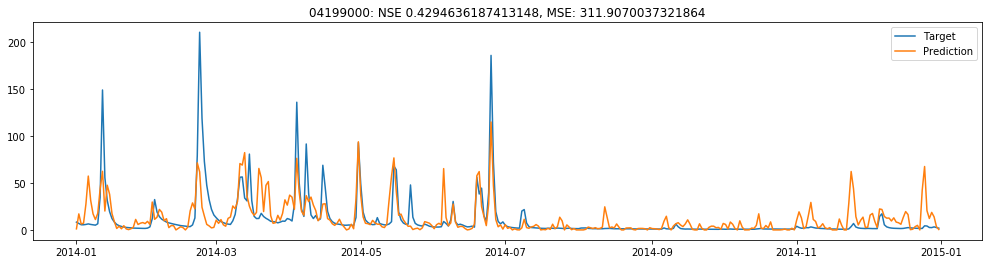

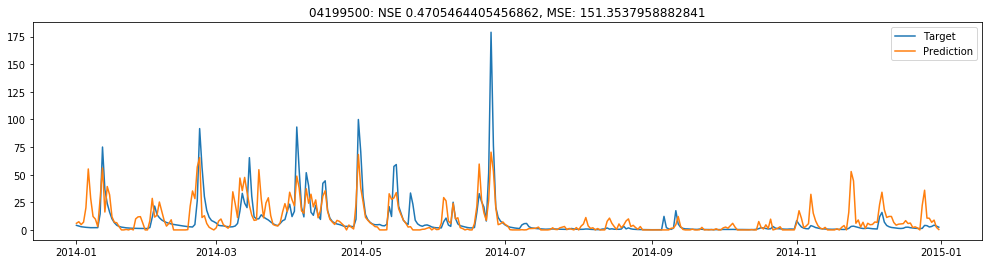

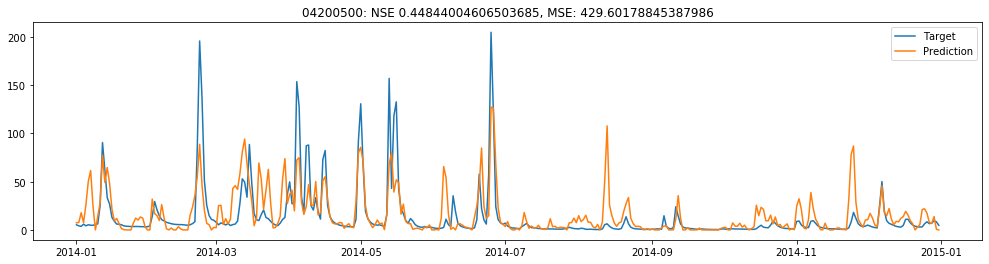

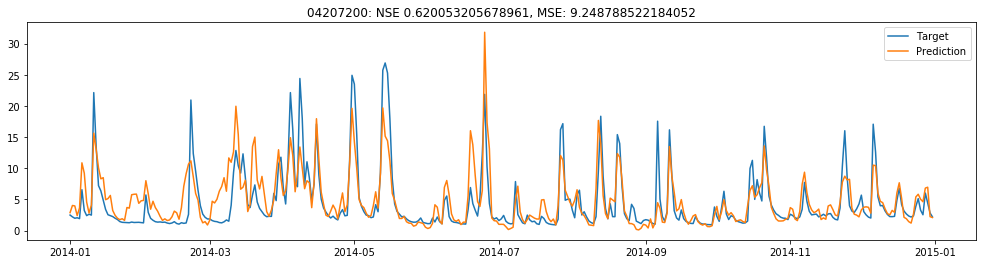

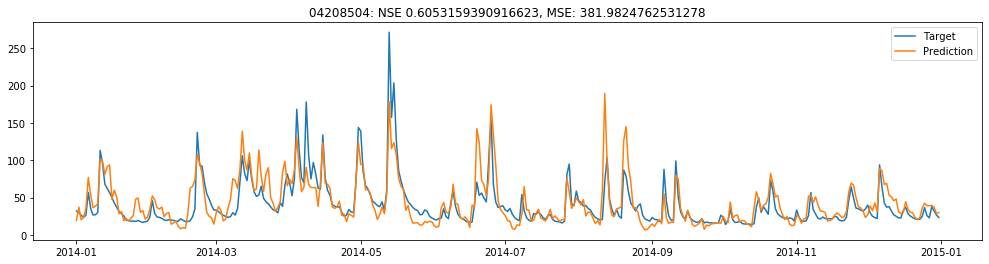

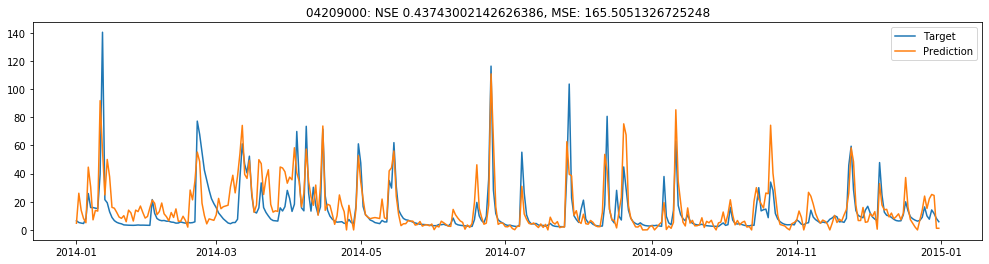

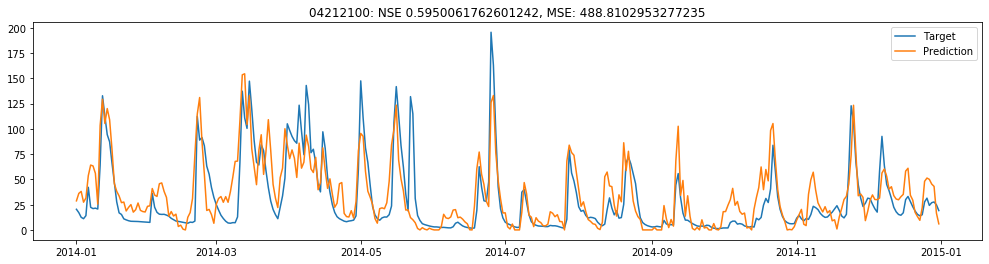

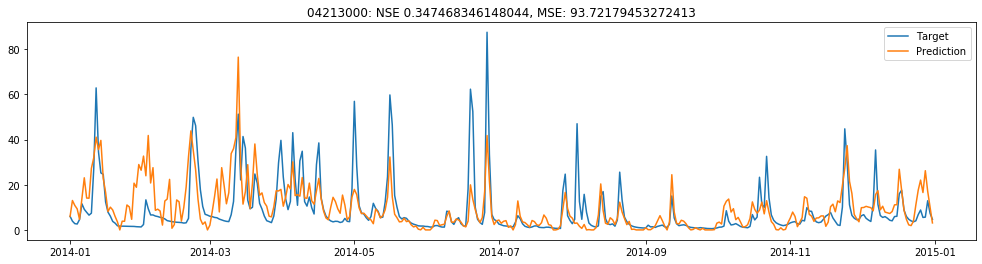

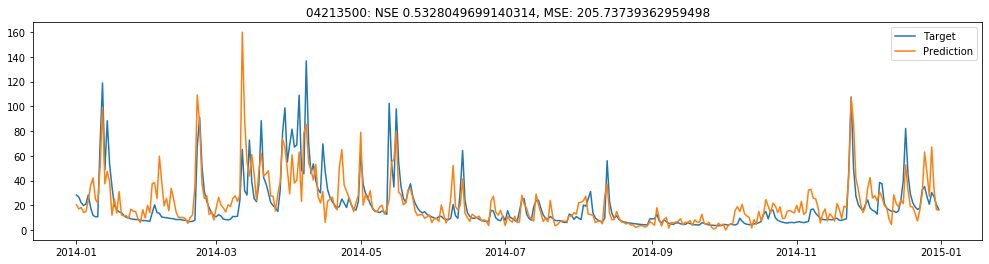

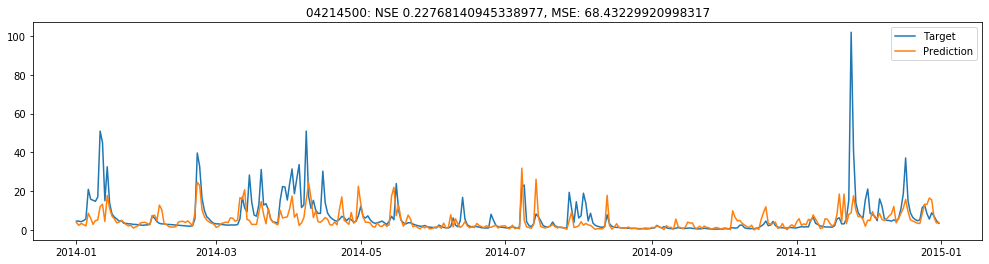

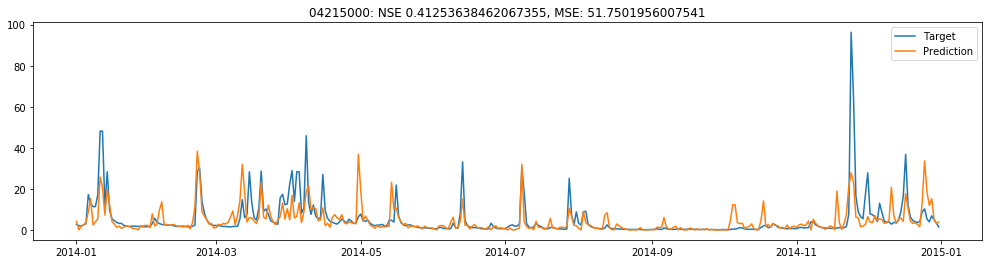

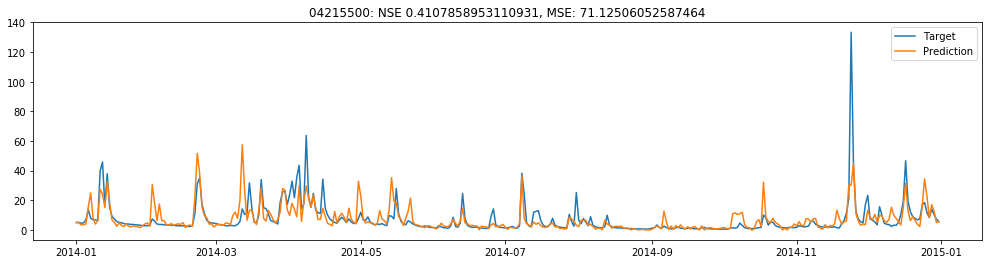

In [5]:
nse_list = []
mse_list = []
for station, predict in predictions.items():
    nse, mse = evaluate.evaluate_daily(station, predict, actuals[station], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings', (predictions, actuals), time_stamp)

'XGBoost_VIC_aggregateForcings_20190704-150411.pkl'

In [7]:
for station, model in models.items():
    load_data.pickle_model('XGBoost_VIC_aggregateForcings', model, station, time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA010_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA018_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA038_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GA047_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB001_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GB007_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC002_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC007_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC010_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC018_20190704-150411.pkl
Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_02GC026_20190704-150411.pkl
Saved mode